# Surface Flux Taylor Series
This notebook uses output from Isca to perform taylor series decompostion on both latent and sensible heat fluxes.

In [231]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile, sphum_sat, clausius_clapeyron_factor
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat, annual_mean
from isca_tools.utils.constants import c_p, R, R_v, kappa, L_v
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize

In [199]:
# Load dataset
var_keep = ['flux_t', 'flux_lhe', 'temp', 'ps', 'sphum', 't_surf', 'w_atm', 'drag_q', 'drag_t', 'rho', 'q_atm', 'q_surf', 't_atm', 'p_atm', 
            'lwdn_sfc', 'lwup_sfc', 'swdn_sfc']
exp_names = ['aquaplanet/no_wishe/k=1', 'aquaplanet/no_wishe/normal_wind']
n_exp = len(exp_names)
use_time_start = 360*2
# only load in atmos level closest to surface, for times after spin up
ds_base = [isca_tools.load_dataset(exp_names[i]).sel(pfull=np.inf, method='nearest')[var_keep] for i in range(n_exp)] 
for i in range(n_exp):
    ds_base[i] = ds_base[i].sel(time=slice(use_time_start, np.inf))
# namelist = isca_tools.load_namelist(exp_names[0])  # Need this for albedo_value
w_atm_const = [isca_tools.load_namelist(exp_names[i])['surface_flux_nml']['w_atm_const'] for i in range(n_exp)]

In [459]:
# Consider a single latitude
loc = {'lat':60}
ds_sl = [ds_base[i].sel(lat=loc['lat'], method='nearest').load() for i in range(n_exp)]
ds_sl_av = [annual_mean(ds_base[i].sel(lat=loc['lat'], method='nearest')).mean(dim='lon').load() for i in range(n_exp)]
n_year_days = 360
time_array = np.arange(n_year_days)

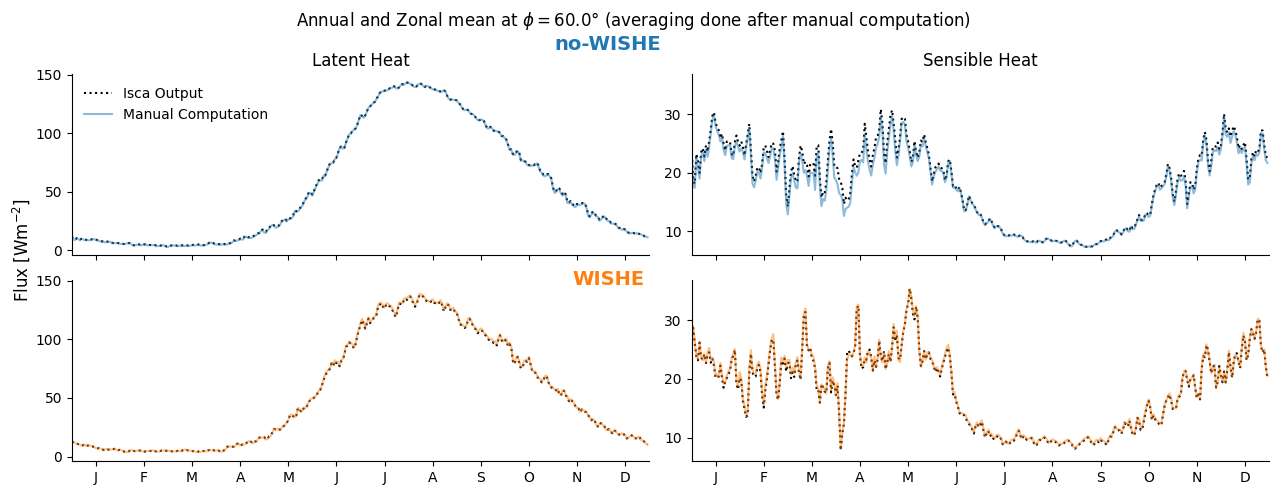

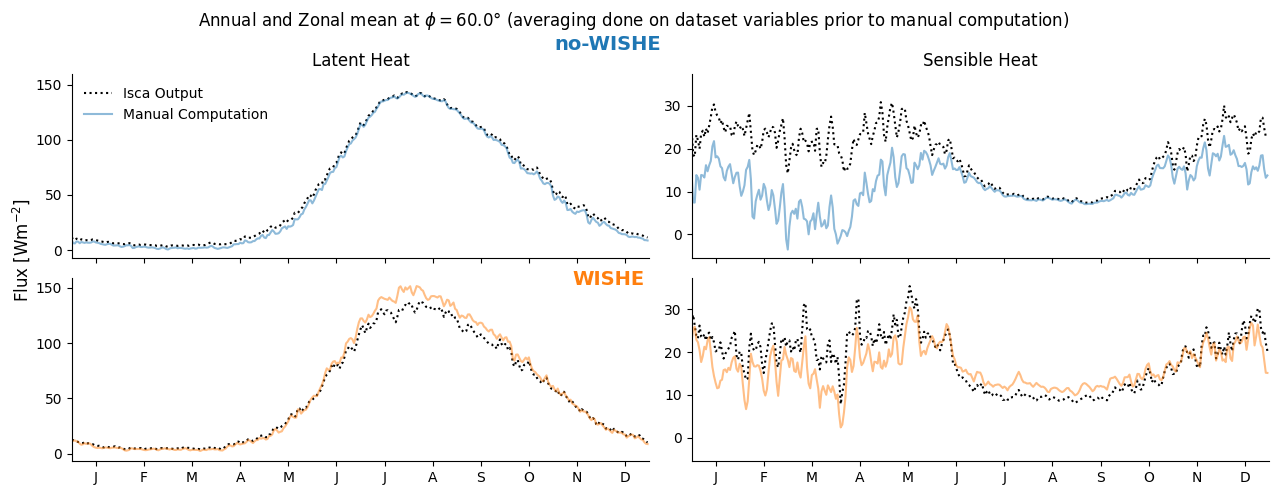

In [460]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
exp_labels = ['no-WISHE', 'WISHE']
# for ds_all in [ds_sl, ds_sl_av, [annual_mean(ds_sl[j]) for j in range(n_exp)], [ds_sl[j].mean(dim='lon') for j in range(n_exp)]]:
for ds_all in [ds_sl, ds_sl_av]:
    w_atm_use = [w_atm_const[i] if w_atm_const[i]>0 else ds_all[i].w_atm for i in range(n_exp)]
    flux_lh_manual = [ds_use.drag_q * w_atm_use[i] * ds_use.rho * (ds_use.q_surf - ds_use.q_atm) * L_v for i, ds_use in enumerate(ds_all)]
    flux_sh_manual = [ds_use.drag_t * w_atm_use[i] * ds_use.rho * (ds_use.t_surf - ds_use.t_atm * (ds_use.ps/ds_use.p_atm)**kappa) * c_p for 
                      i, ds_use in enumerate(ds_all)]
    
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(n_exp,2, figsize=(13, 5), sharex=True, sharey='col')
    take_annual_mean = ds_all[0].time[-1]>n_year_days
    take_zonal_mean = 'lon' in ds_all[0]
    if take_zonal_mean and take_annual_mean:
        av_func = lambda x: annual_mean(x).mean(dim='lon')
        av_title = 'averaging done after manual computation'
    elif take_annual_mean:
        av_func = lambda x: annual_mean(x)
        av_title = 'zonal averaging done on dataset variables prior to manual computation' 
    elif take_zonal_mean:
        av_func = lambda x: x.mean(dim='lon')
        av_title = 'temporal averaging done on dataset variables prior to manual computation' 
    else:
        av_func = lambda x: x
        av_title = 'averaging done on dataset variables prior to manual computation' 
    for i, ds_use in enumerate(ds_all):
        ax[i, 0].spines[['top', 'right']].set_visible(False)
        ax[i, 1].spines[['top', 'right']].set_visible(False)
        ax[i, 0].plot(time_array, av_func(ds_use.flux_lhe), color='k', linestyle=':', label='Isca Output')
        ax[i, 0].plot(time_array, av_func(flux_lh_manual[i]), alpha=0.5, color=default_colors[i], label='Manual Computation')
        
        ax[i, 1].plot(time_array, av_func(ds_use.flux_t), color='k', linestyle=':')
        ax[i, 1].plot(time_array, av_func(flux_sh_manual[i]), alpha=0.5, color=default_colors[i])
        # ax[i, 1].plot(time_array, flux_sh_manual2[i], alpha=0.5)
        
        # ax[1].plot(ds.time, ds.flux_t, color='k', linestyle=':')
        # ax[1].plot(ds.time, flux_sh_manual, alpha=0.5)
        # ax[1].plot(ds.time, flux_sh_manual2, alpha=0.5)
    ax[0, 0].legend(frameon=False)
    ax[0, 0].set_title('Latent Heat')
    ax[0, 1].set_title('Sensible Heat')
    ax[0, 0].set_xticks(*month_ticks)
    ax[0, 0].set_xlim(0, n_year_days)
    plt.figtext(0.48,0.93, "no-WISHE", ha="center", va="top", fontsize=14, color=default_colors[0], fontweight='bold')
    plt.figtext(0.48,0.46, "WISHE", ha="center", va="top", fontsize=14, color=default_colors[1], fontweight='bold')
    fig.supylabel('Flux [Wm$^{-2}$]')
    fig.suptitle(f"Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$ ({av_title})")
    # ax[0].set_ylabel('Flux [W/m$^2$]')
    # fig.supxlabel('Time [days]')
    # fig.suptitle(f"Lat = {loc_use['lat']}$\degree$; Lon = {loc_use['lon']}$\degree$")
    plt.tight_layout()

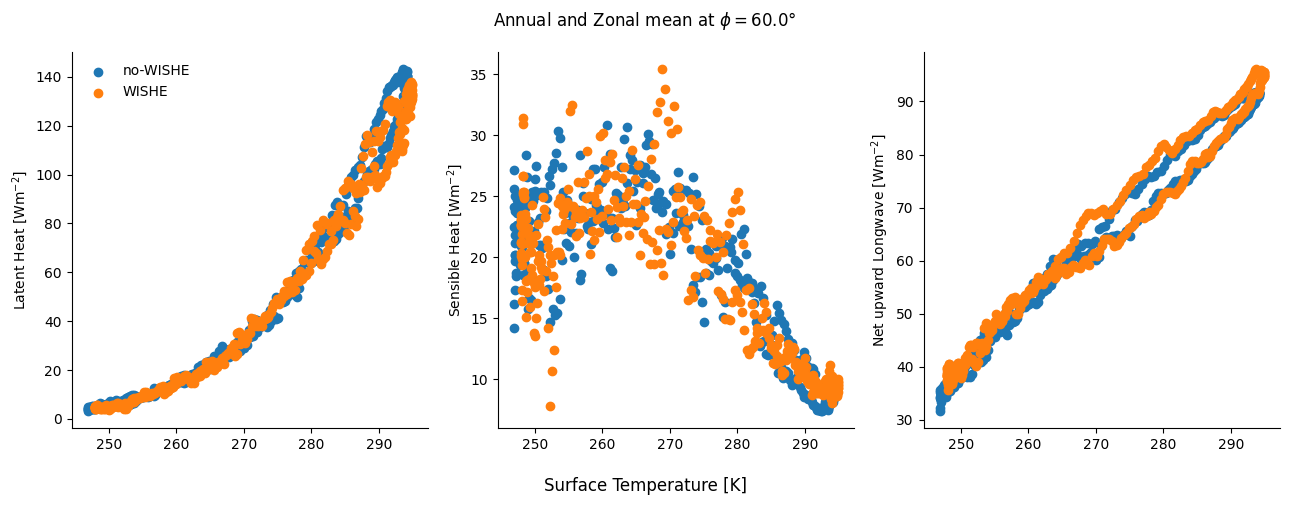

In [461]:
fig, ax = plt.subplots(1,3, figsize=(13, 5), sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[2].spines[['top', 'right']].set_visible(False)
for i in range(n_exp):
    ax[0].scatter(ds_sl_av[i].t_surf, ds_sl_av[i].flux_lhe, color=default_colors[i], label=exp_labels[i])
    ax[1].scatter(ds_sl_av[i].t_surf, ds_sl_av[i].flux_t, color=default_colors[i])
    ax[2].scatter(ds_sl_av[i].t_surf, ds_sl_av[i].lwup_sfc - ds_sl_av[i].lwdn_sfc, color=default_colors[i])
ax[0].legend(frameon=False)
ax[0].set_ylabel('Latent Heat [Wm$^{-2}$]')
ax[1].set_ylabel('Sensible Heat [Wm$^{-2}$]')
ax[2].set_ylabel('Net upward Longwave [Wm$^{-2}$]')
fig.supxlabel('Surface Temperature [K]')
fig.suptitle(f'Annual and Zonal mean at $\phi={round(float(ds_sl_av[0].lat), 1)}\degree$')
plt.tight_layout();

## Latent Heat Taylor Series
The equation for latent heat is $LH = L_v C_q\rho_a |v|(q_s - q_a)$, where $\rho_a = \frac{p_a}{RT_{a_v}}$ and $T_{a_v} = (1+\frac{1-\epsilon}{\epsilon}q_{a})T_{a}$ is the virtual temperature. $a$ indicates the lowest level of the atmosphere and $s$ indicates the surface. It is shown by the blue line below.

Ignoring the virtual temperature correction, this becomes: $LH \approx L_v C_q\frac{p_{a}}{RT_{a}} |v|(q_{s} - q_{a})$, and is shown by the orange line below.

If we substitute $q_{s} = q^*(T_{s})$, we get the green line.

If do a taylor series expansion of q^*(T_a) about $T_s$ and $p_s$, we get $q_a = r_aq^*(T_a) \approx r_aq^*(T_s)(1+\alpha_sT_{a-s})$ where $T_{a-s} = T_a - T_s$ and $r_a$ is the relative humidity. 
From this, we then have $LH \approx L_v C_q\frac{p_{a}}{RT_{a}} |v|q^*_s(1 - r_a(1+\alpha_sT_{a-s}))$ which is shown by the red line below.

Clearly from the plot below, these approximations are all very good. It gives us an expression for latent heat which depends on 7 variables: $p_s$, $p_{a}$, $r_a$, $T_s$, $T_{a-s}$, $|v|$ and $C_q$.
$$LH \approx L_v C_q\frac{p_{a}}{R(T_{s}+T_{a-s})} |v|q^*(T_s, p_s)\big(1 - r_a(1+\alpha(T_s, p_s)T_{a-s})\big)$$

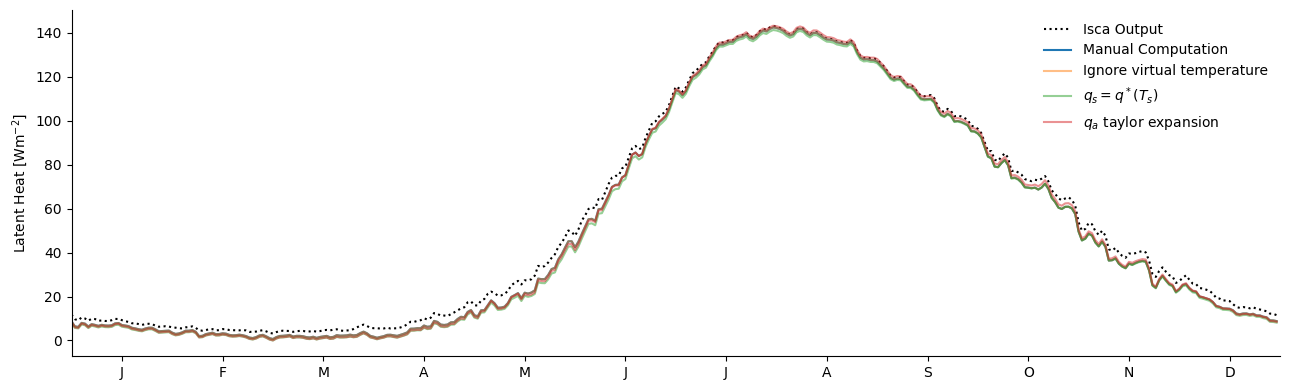

In [462]:
ds_use = ds_sl_av[0]
flux_lh_manual2 = ds_use.drag_q * w_atm_use[0] * (ds_use.p_atm/(R*ds_use.t_atm)) * (ds_use.q_surf - ds_use.q_atm) * L_v
flux_lh_manual3 = ds_use.drag_q * w_atm_use[0] * (ds_use.p_atm/(R*ds_use.t_atm)) * (sphum_sat(ds_use.t_surf, ds_use.ps) - ds_use.q_atm) * L_v
r_a = ds_use.q_atm / sphum_sat(ds_use.t_atm, ds_use.p_atm)
alpha_s_full = clausius_clapeyron_factor(ds_use.t_surf, ds_use.ps)
t_a_s = ds_use.t_atm - ds_use.t_surf
flux_lh_manual4 = ds_use.drag_q * w_atm_use[0] * (ds_use.p_atm/(R*ds_use.t_atm)) * sphum_sat(ds_use.t_surf, ds_use.ps) * \
                  (1 - r_a * (1+alpha_s_full*t_a_s)) * L_v

fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.plot(time_array, ds_use.flux_lhe, color='k', linestyle=':', label='Isca Output')
ax.plot(time_array, flux_lh_manual[0], color=default_colors[0], label='Manual Computation')
ax.plot(time_array, flux_lh_manual2, color=default_colors[1], alpha=0.5, label='Ignore virtual temperature')
ax.plot(time_array, flux_lh_manual3, color=default_colors[2], alpha=0.5, label='$q_{s} = q^*(T_s)$')
ax.plot(time_array, flux_lh_manual4, color=default_colors[3], alpha=0.5, label='$q_{a}$ taylor expansion')
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('Latent Heat [Wm$^{-2}$]')
ax.legend(frameon=False)
plt.tight_layout()

### Final Approximation
The plots below show that $q^*(T_s, p_s) \approx q^*(T_s, \overline{p_s})$ and $\alpha(T_s, p_s) \approx \alpha(T_s, \overline{p_s})$, where $\overline{p_s}$ is the average of surface pressure over all time. This helps simplify further by eliminating the $p_s$ dependence so there are now only 6 variables:
$$LH \approx L_v C_q\frac{p_{a}}{R(T_{s}+T_{a-s})} |v|q^*(T_s)\big(1 - r_a(1+\alpha(T_s)T_{a-s})\big)$$
This final approximation is shown below in orange.

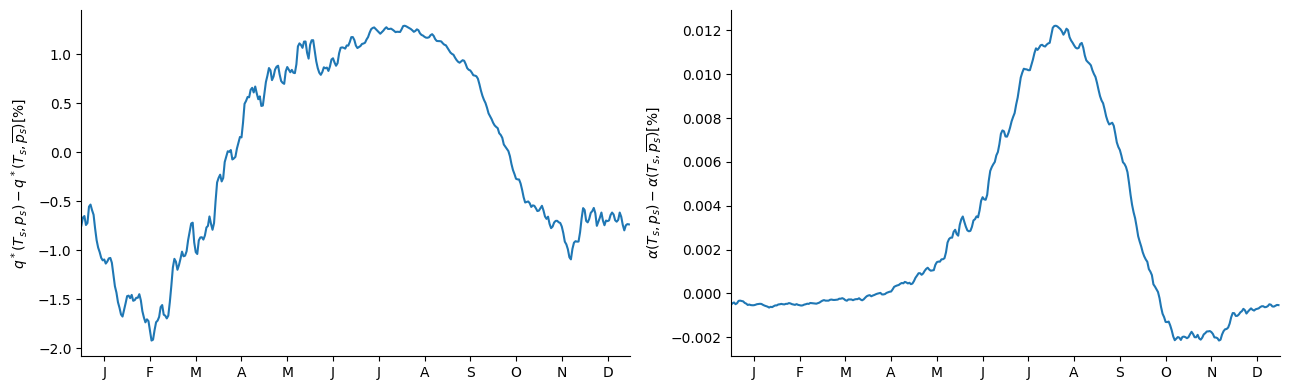

In [463]:
fig, ax = plt.subplots(1,2, figsize=(13, 4), sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[0].plot(time_array, 100*(sphum_sat(ds_use.t_surf, ds_use.ps)-sphum_sat(ds_use.t_surf, ds_use.ps.mean()))/sphum_sat(ds_use.t_surf, ds_use.ps))
ax[1].plot(time_array, 100*(clausius_clapeyron_factor(ds_use.t_surf, ds_use.ps)-clausius_clapeyron_factor(ds_use.t_surf, ds_use.ps.mean()))
           /clausius_clapeyron_factor(ds_use.t_surf, ds_use.ps))
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(0, n_year_days)
ax[0].set_ylabel('$q^*(T_s, p_s) - q^*(T_s, \overline{p_s}) [\%]$')
ax[1].set_ylabel('$\\alpha(T_s, p_s) - \\alpha(T_s, \overline{p_s}) [\%]$')
plt.tight_layout()

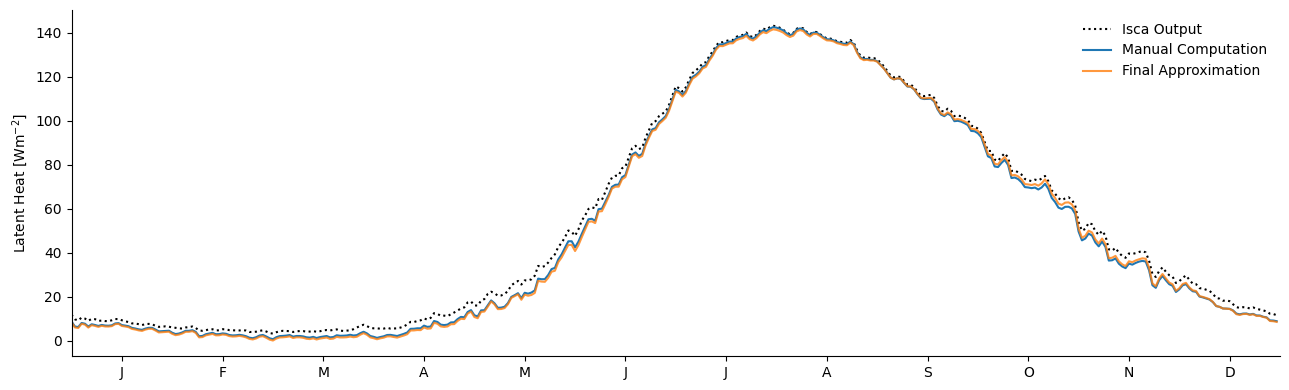

In [464]:
def lh_approx(ds_use, ps, w_a):
    # ds_use - dataset at a single latitude and longitude, with n_year_days values for each variable
    # ps - [float] surface pressure in Pa
    # w_a - [float or DataArray of size n_year_days] lowest level atmospheric wind speed to use. Either constant or one value for each time.
    alpha_s = clausius_clapeyron_factor(ds_use.t_surf, ps)
    r_a = ds_use.q_atm / sphum_sat(ds_use.t_atm, ds_use.p_atm)
    t_a_s = ds_use.t_atm - ds_use.t_surf
    return L_v * ds_use.drag_q * w_a * (ds_use.p_atm/(R*ds_use.t_atm)) * sphum_sat(ds_use.t_surf, ps) * (1 - r_a * (1+alpha_s*t_a_s))

def lh_approx_mean(ds_mean, ps, w_a_mean, r_a_mean, t_a_s_mean):
    alpha_s_mean = clausius_clapeyron_factor(ds_mean.t_surf, ps)
    return L_v * ds_mean.drag_q * w_a_mean * (ds_mean.p_atm/(R*(ds_mean.t_surf+t_a_s_mean))) * sphum_sat(ds_mean.t_surf, ps) * (
            1 - r_a_mean * (1+alpha_s_mean*t_a_s_mean))

fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.plot(time_array, ds_use.flux_lhe, color='k', linestyle=':', label='Isca Output')
ax.plot(time_array, flux_lh_manual[0], color=default_colors[0], label='Manual Computation')
ax.plot(time_array, lh_approx(ds_use, ds_use.ps.mean(), w_atm_use[0]), color=default_colors[1], alpha=0.8, label='Final Approximation')
ax.legend(frameon=False)
ax.set_xticks(*month_ticks)
ax.set_xlim(0, n_year_days)
ax.set_ylabel('Latent Heat [Wm$^{-2}$]')
plt.tight_layout()

### Latent Heat Decomposition


In [465]:
def lh_taylor_decomp(ds_use, ps, w_a, mean_axis=None):
    if isinstance(w_a, float):
        w_a_mean = w_a
    else:
        w_a_mean = w_a.mean(axis=mean_axis)
    
    var = {'t_s': ds_use.t_surf, 't_a_s': ds_use.t_atm - ds_use.t_surf, 'r_a': ds_use.q_atm / sphum_sat(ds_use.t_atm, ds_use.p_atm), 
           'p_a': ds_use.p_atm, 'drag_q': ds_use.drag_q, 'w_a': w_a}
    var_mean = {key: var[key] if isinstance(var[key], float) else float(var[key].mean(axis=mean_axis)) for key in var}
    var_delta = {key: var[key] - var_mean[key] for key in var}
    alpha_s_mean = clausius_clapeyron_factor(var_mean['t_s'], ps)
    lh_mean = float(lh_approx_mean(ds_use.mean(), ps, w_a_mean, var_mean['r_a'], var_mean['t_a_s']))
    
    lh_taylor_coefs = {}
    lh_taylor_terms = {}
    for key in ['w_a', 'drag_q', 'p_a']:
        lh_taylor_coefs[key] = lh_mean/var_mean[key]
    q_s_mean = sphum_sat(var_mean['t_s'], ps)
    pre_factor_mean = L_v * var_mean['drag_q'] * var_mean['w_a'] * var_mean['p_a']/(R*(var_mean['t_s']+var_mean['t_a_s']))
    
    lh_taylor_coefs['r_a'] = -pre_factor_mean * q_s_mean * (1+alpha_s_mean*var_mean['t_a_s'])
    lh_taylor_coefs['t_a_s'] = -lh_mean/(var_mean['t_s']+var_mean['t_a_s'])-var_mean['r_a']*alpha_s_mean*pre_factor_mean*q_s_mean
    # Full form
    # lh_taylor_coefs['t_s'] = lh_mean * (alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s'])
    #                                     ) + 2*alpha_s_mean * var_mean['r_a'] * var_mean['t_a_s'] / var_mean['t_s'] * pre_factor_mean * q_s_mean
    # Simple form
    lh_taylor_coefs['t_s'] = lh_mean * (alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s']))
    # From simpler t_s form
    lh_taylor_coefs['t_s_squared'] = lh_mean * ((alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s']))**2 + 
                                                (1/(var_mean['t_s']+var_mean['t_a_s'])**2 - 2*alpha_s_mean/var_mean['t_s']))
    
    lh_taylor_coefs['t_s_r_a'] = lh_taylor_coefs['t_s']/lh_mean * lh_taylor_coefs['r_a']
    lh_taylor_coefs['t_s_squared_r_a'] = lh_taylor_coefs['t_s_squared']/lh_mean * lh_taylor_coefs['r_a']
    lh_taylor_coefs['t_s_t_a_s'] = lh_mean/(var_mean['t_s']+var_mean['t_a_s'])**2 + (
            alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s'])) * lh_taylor_coefs['t_a_s']
    lh_taylor_coefs['t_s_squared_t_a_s'] = lh_mean * (2/(var_mean['t_s']+var_mean['t_a_s'])**2 * (alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s'])) - 
                                                      2/(var_mean['t_s']+var_mean['t_a_s'])**3) + \
                                           lh_taylor_coefs['t_a_s']/lh_mean * lh_taylor_coefs['t_s_squared']
    lh_taylor_coefs['t_s_cubed'] = lh_mean * (6*alpha_s_mean/var_mean['t_s']**2 - 2/(var_mean['t_s']+var_mean['t_a_s'])**3 + 
                                              2*(alpha_s_mean - 1/(var_mean['t_s']+var_mean['t_a_s']))*
                                              (1/(var_mean['t_s']+var_mean['t_a_s'])**2-2*alpha_s_mean/var_mean['t_s'])) + \
                                   lh_taylor_coefs['t_s_squared']/lh_mean * lh_taylor_coefs['t_s']
    lh_taylor_coefs['t_s_cubed_r_a'] = lh_taylor_coefs['t_s_cubed']/lh_mean * lh_taylor_coefs['r_a']
    lh_taylor_coefs['r_a_t_a_s'] = -lh_taylor_coefs['r_a']/(var_mean['t_s']+var_mean['t_a_s']) - alpha_s_mean * pre_factor_mean * q_s_mean
    
    
    var_delta['t_s_squared'] = 0.5 * var_delta['t_s']**2
    var_delta['t_s_r_a'] = var_delta['t_s'] * var_delta['r_a']
    var_delta['t_s_squared_r_a'] = 0.5 * var_delta['t_s']**2 * var_delta['r_a']
    var_delta['t_s_t_a_s'] = var_delta['t_s'] * var_delta['t_a_s']
    var_delta['t_s_squared_t_a_s'] = 0.5 * var_delta['t_s']**2 * var_delta['t_a_s']
    var_delta['t_s_cubed'] = 1/6 * var_delta['t_s']**3
    var_delta['t_s_cubed_r_a'] = 1/6 * var_delta['t_s']**3 * var_delta['r_a']
    var_delta['r_a_t_a_s'] = var_delta['r_a'] * var_delta['t_a_s']
    for key in lh_taylor_coefs:
        lh_taylor_terms[key] = var_delta[key] * lh_taylor_coefs[key]
    return lh_mean, lh_taylor_terms
    
a = lh_taylor_decomp(ds_use, ds_use.ps.mean(), w_atm_use[0]) 

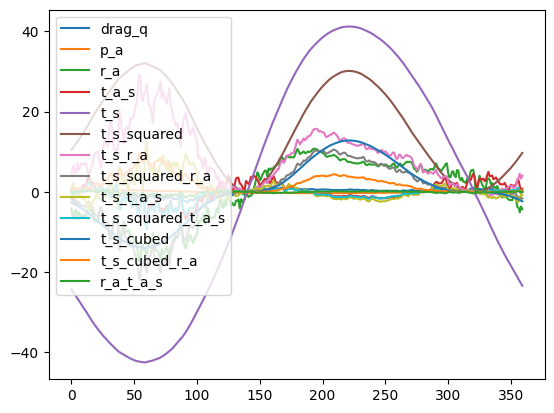

In [466]:
for key in a[1]:
    if key != 'w_a':
        plt.plot(time_array, a[1][key], label=key)
plt.legend()

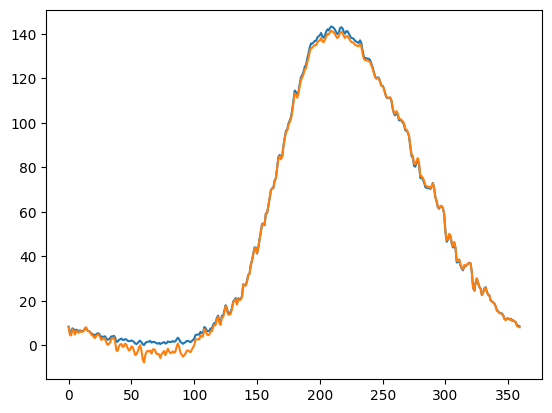

In [467]:
plt.plot(flux_lh_manual4)
plt.plot(a[0]+sum(a[1].values()))
# plt.plot(2*(ds_use.t_surf - ds_use.t_surf.mean()))